In [28]:
import os
import re
import random
from argparse import Namespace

import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.notebook import tqdm
import torchaudio
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy

import sacrebleu
import sentencepiece

from fairseq import utils
from fairseq.data import PhonemeDictionary, Dictionary, data_utils as fairseq_data_utils
from fairseq.models.speech_to_text.xstnet import XSTNet
from fairseq.data.audio.speech_text_triple_align_dataset import (
    SpeechTextTripleAlignDataset
)
from fairseq.criterions.multitask_crossentropy_with_contrastive_token_with_extra_mt import MultiTaskCrossEntropyWithContrastiveTokenWithExtraMT
from fairseq.data.audio.speech_to_text_dataset import get_features_or_waveform, _collate_frames
from ConST.prepare_data.data_utils import load_df_from_tsv, save_df_to_tsv
from fairseq.checkpoint_utils import load_checkpoint_to_cpu, save_state, torch_persistent_save

In [29]:
device = 'cuda:7'

# Load Checkpoint

In [30]:
args = Namespace()
task = Namespace()

args.w2v2_model_path = '/mnt/data/siqiouyang/runs/mST/pretrained/wav2vec_small.pt'

args.max_audio_positions = 600000
args.max_source_positions = 1024
args.max_target_positions = 1024
args.max_audio_tokens = 1000000
args.max_text_tokens = 2000
args.max_tokens = 1000000
args.max_tokens_valid = 2000000

src_dict = PhonemeDictionary.load('/mnt/data/siqiouyang/datasets/must-c-v1.0/phonemes.txt')
tgt_dict = Dictionary.load('/mnt/data/siqiouyang/datasets/must-c-v1.0/spm_unigram10000_st_de.txt')
task.source_dictionary = src_dict
task.target_dictionary = tgt_dict

model = XSTNet.build_model(args, task)
model2 = XSTNet.build_model(args, task)

In [31]:
tag = 'ablation_data_efficiency_1h_baseline'
tag2 = 'ablation_data_efficiency_10h_baseline'

In [32]:
ckpt_path = '/mnt/data/siqiouyang/runs/ConST/{}/checkpoint_best.pt'.format(tag)
ckpt = load_checkpoint_to_cpu(ckpt_path)

ckpt_path2 = '/mnt/data/siqiouyang/runs/ConST/{}/checkpoint_best.pt'.format(tag2)
ckpt2 = load_checkpoint_to_cpu(ckpt_path2)

In [33]:
model.load_state_dict(ckpt['model'], strict=False)
model = model.to(device)

model2.load_state_dict(ckpt2['model'], strict=False)
model2 = model2.to(device)

In [48]:
n_element = 0
for t in model.parameters():
    n_element += t.numel()
print(n_element)

150860800


# Compute Feature

In [34]:
spm = sentencepiece.SentencePieceProcessor()
spm.Load('/mnt/data/siqiouyang/datasets/must-c-v1.0/spm_unigram10000_st_de.model')

True

In [35]:
df = load_df_from_tsv('/mnt/data/siqiouyang/datasets/must-c-v1.0/tst-COMMON_st_de.tsv')

In [36]:
def compute_feature(model, idx):
    align_path = '/mnt/data/siqiouyang/datasets/must-c-v1.0/en-de/data/tst-COMMON/align/{}.pt'.format(df['id'][idx])
    if os.path.exists(align_path):
        audio_path = os.path.join('/mnt/data/siqiouyang/datasets/must-c-v1.0', df['audio'][idx])
        audio = get_features_or_waveform(audio_path, need_waveform=True).to(device)
        
        src_tokens = spm.EncodeAsPieces(df['src_text'][idx])
        tokenized =  " ".join(spm.EncodeAsPieces(df['src_text'][idx]))
        src_text = tgt_dict.encode_line(
            tokenized, add_if_not_exist=False, append_eos=True
        ).long()
        lang_tag = SpeechTextTripleAlignDataset.LANG_TAG_TEMPLATE.format(df['src_lang'][idx])
        lang_tag_idx = tgt_dict.index(lang_tag)
        src_text = th.cat((th.LongTensor([lang_tag_idx]), src_text), 0).unsqueeze(0).to(device)

        n_frame = th.LongTensor([audio.size(1)]).to(device)
        src_length = th.LongTensor([src_text.size(1)])

        tokenized = " ".join(spm.EncodeAsPieces(df['tgt_text'][idx]))
        tgt_text = tgt_dict.encode_line(
            tokenized, add_if_not_exist=False, append_eos=True
        ).long()
        lang_tag = SpeechTextTripleAlignDataset.LANG_TAG_TEMPLATE.format(df['tgt_lang'][idx])
        lang_tag_idx = tgt_dict.index(lang_tag)
        tgt_text = th.cat((th.LongTensor([lang_tag_idx]), tgt_text), 0)

        target = fairseq_data_utils.collate_tokens(
            [tgt_text],
            tgt_dict.pad(),
            tgt_dict.eos(),
            left_pad=False,
            move_eos_to_beginning=False,
        ).to(device)
        prev_output_target_tokens = fairseq_data_utils.collate_tokens(
            [tgt_text],
            tgt_dict.pad(),
            tgt_dict.eos(),
            left_pad=False,
            move_eos_to_beginning=True,
        ).to(device)

        with th.no_grad():
            st_encoder_out = model.encoder(audio.to(device), n_frame.to(device))
            st_x = st_encoder_out.encoder_embedding.squeeze(1)
            mt_encoder_out = model.encoder(src_text.to(device), src_length.to(device), is_text_input=True)
            mt_x = mt_encoder_out.encoder_embedding.squeeze(1)

        words = []

        seg, itv = th.load(align_path)
        seg = [(s[0] + 1, s[1] + 1) for s in seg]
        itv = (itv * st_encoder_out.encoder_padding_mask.size(1)).astype(int)
        st_f = []
        mt_f = []
        starts = []
        for (t_l, t_r), (s_l, s_r) in zip(seg, itv):
            st_f.append(st_x[s_l : s_r + 1].mean(dim=0))
            mt_f.append(mt_x[t_l : t_r + 1].mean(dim=0))

            words.append(''.join(src_tokens[t_l - 1 : t_r]).replace('▁', ''))
            starts.append((s_l + s_r) // 2)
            
        st_f = th.stack(st_f, dim=0)
        mt_f = th.stack(mt_f, dim=0)
        
        return st_x, mt_x, st_f, mt_f, src_tokens, audio, words, starts
    else:
        return None

In [37]:
st_xs = []
mt_xs = []
st_fs = []
mt_fs = []
for idx in tqdm(range(len(df))):
    result = compute_feature(model, idx)
    if result is not None:
        st_x, mt_x, st_f, mt_f, _, _, _, _ = result
        st_xs.append(st_x.mean(dim=0))
        mt_xs.append(mt_x.mean(dim=0))
        st_fs.append(st_f)
        mt_fs.append(mt_f)
st_xs = th.stack(st_xs, dim=0)
mt_xs = th.stack(mt_xs, dim=0)
st_fs = th.cat(st_fs, dim=0)
mt_fs = th.cat(mt_fs, dim=0)

  0%|          | 0/2587 [00:00<?, ?it/s]

In [39]:
st_xs_2 = []
mt_xs_2 = []
st_fs_2 = []
mt_fs_2 = []
for idx in tqdm(range(len(df))):
    result = compute_feature(model2, idx)
    if result is not None:
        st_x, mt_x, st_f, mt_f, _, _, _, _ = result
        st_xs_2.append(st_x.mean(dim=0))
        mt_xs_2.append(mt_x.mean(dim=0))
        st_fs_2.append(st_f)
        mt_fs_2.append(mt_f)
st_xs_2 = th.stack(st_xs_2, dim=0)
mt_xs_2 = th.stack(mt_xs_2, dim=0)
st_fs_2 = th.cat(st_fs_2, dim=0)
mt_fs_2 = th.cat(mt_fs_2, dim=0)

  0%|          | 0/2587 [00:00<?, ?it/s]

# Average Cosine Similarity

In [40]:
sim = F.cosine_similarity(st_fs, mt_fs, dim=-1).mean()
sim2 = F.cosine_similarity(st_fs_2, mt_fs_2, dim=-1).mean()
sim, sim2

(tensor(-0.0074, device='cuda:7'), tensor(0.2636, device='cuda:7'))

In [33]:
sim = F.cosine_similarity(st_xs, mt_xs, dim=-1).mean()
sim2 = F.cosine_similarity(st_xs_2, mt_xs_2, dim=-1).mean()
sim, sim2

(tensor(0.2748, device='cuda:4'), tensor(0.3408, device='cuda:4'))

In [44]:
sims = F.cosine_similarity(
    st_xs.unsqueeze(1),
    mt_xs.unsqueeze(0),
    dim=-1
)
(sims.argmax(dim=-1) == th.arange(sims.size(0)).to(device)).float().mean()

tensor(0.7510, device='cuda:4')

In [43]:
sims2 = F.cosine_similarity(
    st_xs_2.unsqueeze(1),
    mt_xs_2.unsqueeze(0),
    dim=-1
)
(sims.argmax(dim=-1) == th.arange(sims.size(0)).to(device)).float().mean()

tensor(0.7510, device='cuda:4')

# Compute Alignment and Uniformity

In [75]:
norm_st_fs = st_fs / st_fs.norm(dim=-1).unsqueeze(-1)
norm_mt_fs = mt_fs / mt_fs.norm(dim=-1).unsqueeze(-1)

## Alignment

In [61]:
alpha = 2

In [62]:
alignment = ((norm_st_fs - norm_mt_fs).norm(dim=-1) ** alpha).mean()
alignment

tensor(1.1140, device='cuda:0')

In [63]:
# token: 1.0117
# ctc:   1.8957
# sent:  1.0291

In [64]:
# token_ft_1h: 0.9807
# ctc_ft_1h:   1.8536
# sent_ft_1h:  1.1138

In [65]:
# main_token: 1.0476
# main_sent:  1.2542

In [76]:
F.cosine_similarity(
    norm_st_fs, norm_mt_fs, dim=-1
).mean()

tensor(0.0741, device='cuda:0')

In [77]:
# token_ft_1h: 0.5084
# sent_ft_1h:  0.4430
# ctc_ft_1h:   0.0741

## Uniformity

In [34]:
t = 1

In [35]:
sum = 0
for st_f in tqdm(norm_st_fs):
    sum += th.exp(-t * ((st_f - norm_st_fs).norm(dim=-1) ** 2)).sum()
sum /= st_fs.size(0) * st_fs.size(0)
uniformity = th.log(sum)
uniformity

  0%|          | 0/25326 [00:00<?, ?it/s]

tensor(-1.8912, device='cuda:0')

In [36]:
# token: -1.9546
# ctc:   -1.3523
# sent:  -1.9599

In [37]:
# token_ft_1h: -1.9266
# ctc_ft_1h:   -1.6424
# sent_ft_1h:  -1.8112

In [38]:
# main_token: -1.9434
# main_sent:  -1.8912

# Test CTC

In [22]:
words

['The', 'first', 'is', 'that', 'we', 'will', 'not', 'evolve']

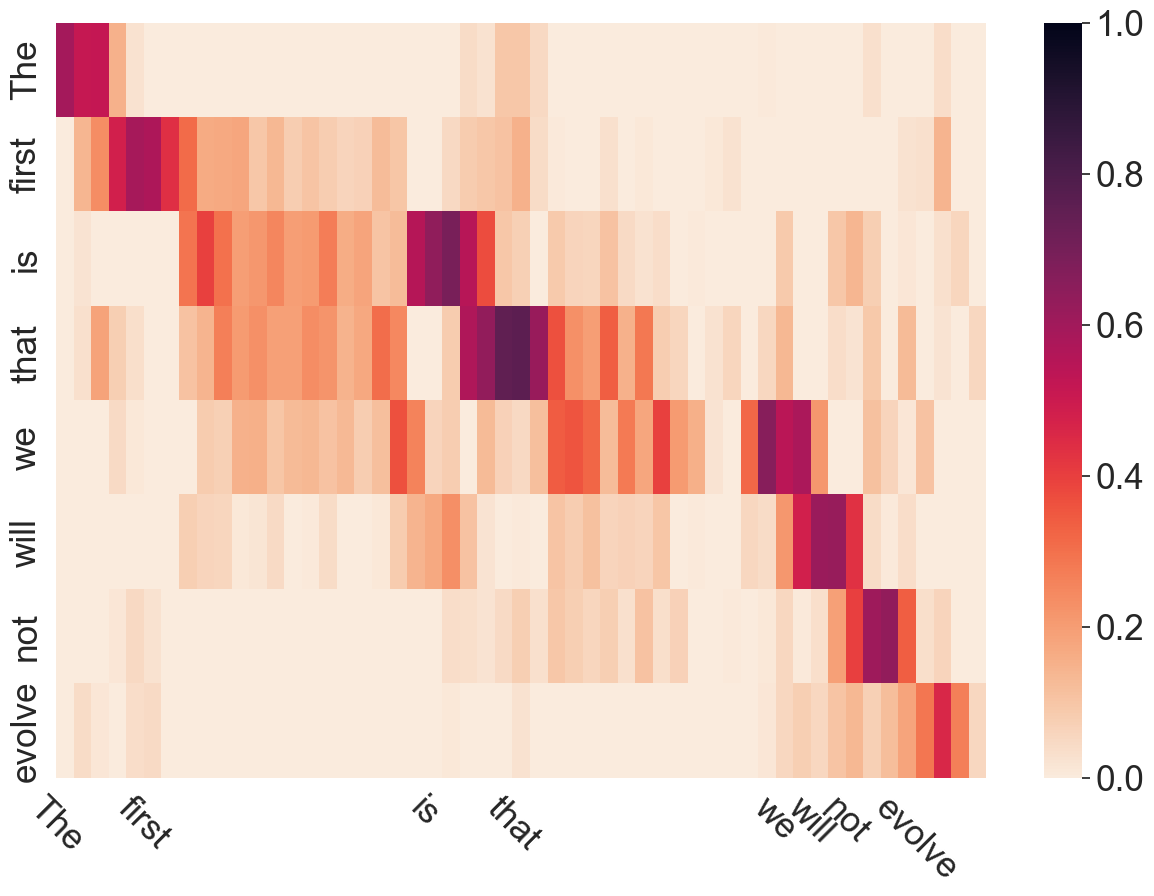

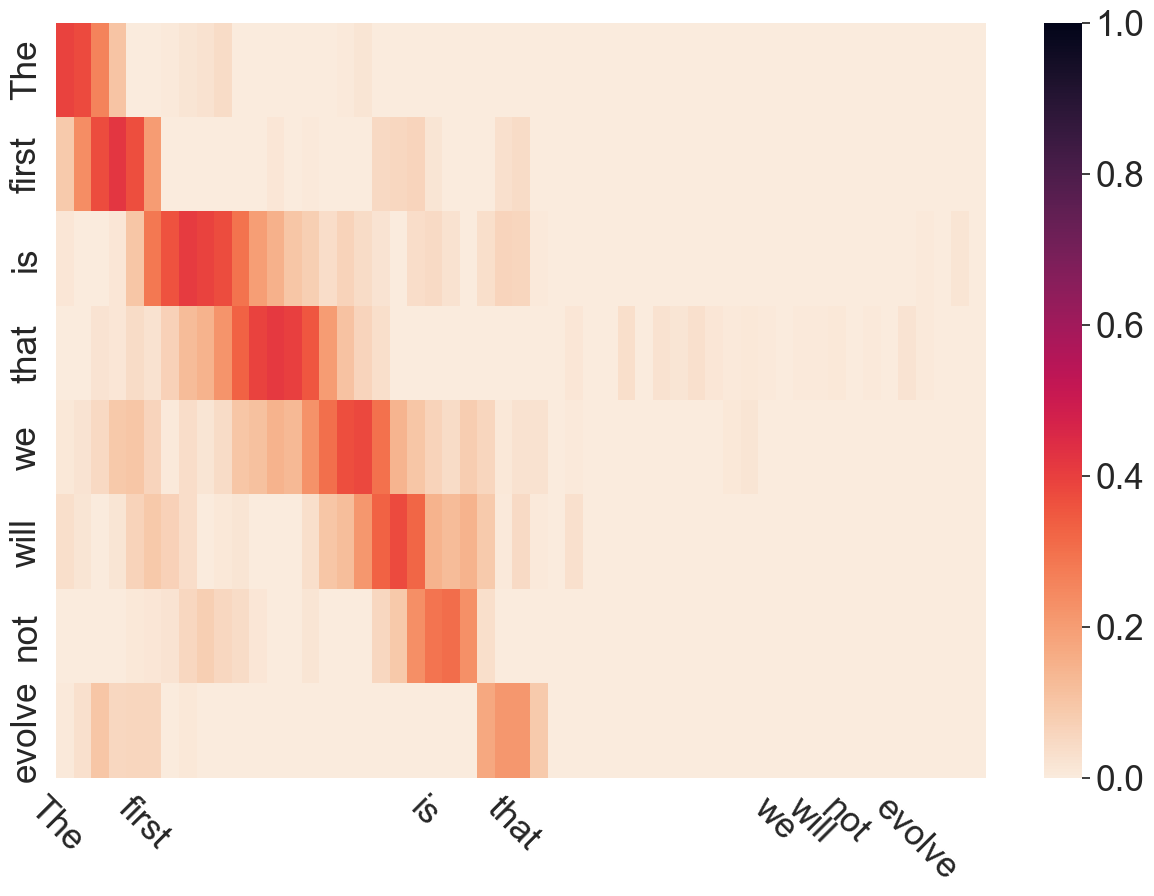

In [27]:
df_idx = 446

sns.set(font_scale=2.3)

st_x, mt_x, st_f, mt_f, src_tokens, audio, words, starts = compute_feature(model, df_idx)
sim_matrix = F.cosine_similarity(
    mt_f.unsqueeze(1),
    st_x.unsqueeze(0),
    dim=-1
)
plt.figure(dpi=100, figsize=(15, 10))
sns.heatmap(sim_matrix.detach().cpu(), yticklabels=words, vmin=0, vmax=1, cmap='rocket_r')
plt.xticks(ticks=starts, labels=words, rotation=-45)
plt.savefig('/home/siqiouyang/work/projects/ConST/ConST/analysis/ctc/good_alignment.pdf')

st_x, mt_x, st_f, mt_f, src_tokens, audio, words, starts = compute_feature(model2, df_idx)
sim_matrix = F.cosine_similarity(
    mt_f.unsqueeze(1),
    st_x.unsqueeze(0),
    dim=-1
)
plt.figure(dpi=100, figsize=(15, 10))
sns.heatmap(sim_matrix.detach().cpu(), yticklabels=words, vmin=0, vmax=1, cmap='rocket_r')
plt.xticks(ticks=starts, labels=words, rotation=-45)
plt.savefig('/home/siqiouyang/work/projects/ConST/ConST/analysis/ctc/bad_alignment.pdf')

torchaudio.save('sample.wav', audio.cpu(), 16000)

In [19]:
df_idx = 7

st_x, mt_x, st_f, mt_f, src_tokens, audio, words = compute_feature(model, df_idx)
sim_matrix = F.cosine_similarity(
    mt_f.unsqueeze(1),
    st_f.unsqueeze(0),
    dim=-1
)
plt.figure(dpi=100, figsize=(15, 10))
sns.heatmap(sim_matrix.detach().cpu(), yticklabels=words, vmin=0, vmax=1)

st_x, mt_x, st_f, mt_f, src_tokens, audio, words = compute_feature(model2, df_idx)
sim_matrix = F.cosine_similarity(
    mt_f.unsqueeze(1),
    st_f.unsqueeze(0),
    dim=-1
)
plt.figure(dpi=100, figsize=(15, 10))
sns.heatmap(sim_matrix.detach().cpu(), yticklabels=words, vmin=0, vmax=1)

torchaudio.save('sample.wav', audio.cpu(), 16000)

TypeError: cannot unpack non-iterable NoneType object